# Functional Expansions
OpenMC's general tally system accommodates a wide range of tally *filters*. While most filters are meant to identify regions of phase space that contribute to a tally, there are a special set of functional expansion filters that will multiply the tally by a set of orthogonal functions, e.g. Legendre polynomials, so that continuous functions of space or angle can be reconstructed from the tallied moments.

In this example, we will determine the spatial dependence of the flux along the $z$ axis by making a Legendre polynomial expansion. Let us represent the flux along the z axis, $\phi(z)$, by the function

$$ \phi(z') = \sum\limits_{n=0}^N a_n P_n(z') $$

where $z'$ is the position normalized to the range [-1, 1]. Since $P_n(z')$ are known functions, our only task is to determine the expansion coefficients, $a_n$. By the orthogonality properties of the Legendre polynomials, one can deduce that the coefficients, $a_n$, are given by

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z').$$

Thus, the problem reduces to finding the integral of the flux times each Legendre polynomial -- a problem which can be solved by using a Monte Carlo tally. By using a Legendre polynomial filter, we obtain stochastic estimates of these integrals for each polynomial order.

In [1]:
%matplotlib inline
import openmc
import numpy as np
import matplotlib.pyplot as plt

To begin, let us first create a simple model. The model will be a slab of fuel material with reflective boundaries conditions in the x- and y-directions and vacuum boundaries in the z-direction. However, to make the distribution slightly more interesting, we'll put some B<sub>4</sub>C in the middle of the slab.

In [2]:
# Define fuel and B4C materials
fuel = openmc.Material()
fuel.add_element('U', 1.0, enrichment=4.5)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.0)

b4c = openmc.Material()
b4c.add_element('B', 4.0)
b4c.add_element('C', 1.0)
b4c.set_density('g/cm3', 2.5)

In [3]:
# Define surfaces used to construct regions
zmin, zmax = -10., 10.
box = openmc.model.rectangular_prism(10., 10., boundary_type='reflective')
bottom = openmc.ZPlane(z0=zmin, boundary_type='vacuum')
boron_lower = openmc.ZPlane(z0=-0.5)
boron_upper = openmc.ZPlane(z0=0.5)
top = openmc.ZPlane(z0=zmax, boundary_type='vacuum')

# Create three cells and add them to geometry
fuel1 = openmc.Cell(fill=fuel, region=box & +bottom & -boron_lower)
absorber = openmc.Cell(fill=b4c, region=box & +boron_lower & -boron_upper)
fuel2 = openmc.Cell(fill=fuel, region=box & +boron_upper & -top)
geom = openmc.Geometry([fuel1, absorber, fuel2])

For the starting source, we'll use a uniform distribution over the entire box geometry.

In [4]:
settings = openmc.Settings()
spatial_dist = openmc.stats.Box(*geom.bounding_box)
settings.source = openmc.Source(space=spatial_dist)
settings.batches = 210
settings.inactive = 10
settings.particles = 1000

Defining the tally is relatively straightforward. One simply needs to list 'flux' as a score and then add an expansion filter. For this case, we will want to use the `SpatialLegendreFilter` class which multiplies tally scores by Legendre polynomials evaluated on normalized spatial positions along an axis.

In [5]:
# Create a flux tally
flux_tally = openmc.Tally()
flux_tally.scores = ['flux']

# Create a Legendre polynomial expansion filter and add to tally
order = 8
expand_filter = openmc.SpatialLegendreFilter(order, 'z', zmin, zmax)
flux_tally.filters.append(expand_filter)

The last thing we need to do is create a `Tallies` collection and export the entire model, which we'll do using the `Model` convenience class.

In [6]:
tallies = openmc.Tallies([flux_tally])
model = openmc.model.Model(geometry=geom, settings=settings, tallies=tallies)

Running a simulation is now as simple as calling the `run()` method of `Model`.

In [7]:
sp_file = model.run(output=False)

Now that the run is finished, we need to load the results from the statepoint file.

In [8]:
with openmc.StatePoint(sp_file) as sp:
    df = sp.tallies[flux_tally.id].get_pandas_dataframe()

We've used the `get_pandas_dataframe()` method that returns tally data as a Pandas dataframe. Let's see what the raw data looks like.

In [9]:
df

,spatiallegendre,nuclide,score,mean,std. dev.
0,P0,total,flux,36.538951,0.078499
1,P1,total,flux,-0.012072,0.043053
2,P2,total,flux,-4.419424,0.025499
3,P3,total,flux,-0.005595,0.021585
4,P4,total,flux,-0.277076,0.013788
5,P5,total,flux,0.001362,0.011802
6,P6,total,flux,0.124089,0.009633
7,P7,total,flux,0.004958,0.008716
8,P8,total,flux,-0.102922,0.007807


Since the expansion coefficients are given as

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z')$$

we just need to multiply the Legendre moments by $(2n + 1)/2$.

In [10]:
n = np.arange(order + 1)
a_n = (2*n + 1)/2 * df['mean']

To plot the flux distribution, we can use the `numpy.polynomial.Legendre` class which represents a truncated Legendre polynomial series. Since we really want to plot $\phi(z)$ and not $\phi(z')$ we first need to perform a change of variables. Since

$$ \lvert \phi(z) dz \rvert = \lvert \phi(z') dz' \rvert $$

and, for this case, $z = 10z'$, it follows that

$$ \phi(z) = \frac{\phi(z')}{10} = \sum_{n=0}^N \frac{a_n}{10} P_n(z'). $$

In [11]:
phi = np.polynomial.Legendre(a_n/10, domain=(zmin, zmax))

Let's plot it and see how our flux looks!

Text(0, 0.5, 'Flux [n/src]')

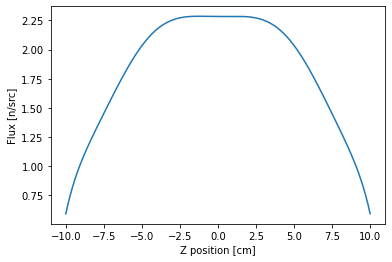

In [12]:
z = np.linspace(zmin, zmax, 1000)
plt.plot(z, phi(z))
plt.xlabel('Z position [cm]')
plt.ylabel('Flux [n/src]')

As you might expect, we get a rough cosine shape but with a flux depression in the middle due to the boron slab that we introduced. To get a more accurate distribution, we'd likely need to use a higher order expansion.

One more thing we can do is confirm that integrating the distribution gives us the same value as the first moment (since $P_0(z') = 1$). This can easily be done by numerically integrating using the trapezoidal rule:

In [13]:
np.trapz(phi(z), z)

36.53891107688235

In addition to being able to tally Legendre moments, there are also functional expansion filters available for spherical harmonics (`SphericalHarmonicsFilter`) and Zernike polynomials over a unit disk (`ZernikeFilter`). A separate `LegendreFilter` class can also be used for determining Legendre scattering moments (i.e., an expansion of the scattering cosine, $\mu$).

## Zernike polynomials

Now let's look at an example of functional expansion tallies using Zernike polynomials as the basis functions.

In this example, we will determine the spatial dependence of the flux along the radial direction $r'$ and $/$ or azimuthal angle $\theta$ by making a Zernike polynomial expansion. Let us represent the flux along the radial and azimuthal direction, $\phi(r', \theta)$, by the function

$$ \phi(r', \theta) = \sum\limits_{n=0}^N \sum\limits_{m=-n}^n a_n^m Z_n^m(r', 
\theta) $$

where $r'$ is the position normalized to the range [0, r] (r is the radius of cylindrical geometry), and the azimuthal lies within the range [0, $ 2\pi$]. 

Since $Z_n^m(r', \theta)$ are known functions, we need to determine the expansion coefficients, $a_n^m$. By the orthogonality properties of the Zernike polynomials, one can deduce that the coefficients, $a_n^m$, are given by

$$ a_n^m = k_n^m \int_{0}^r dr' \int_{0}^{2\pi} d\theta Z_n^m(r',\theta) \phi(r', \theta).$$
$$ k_n^m = \frac{2n + 2}{\pi}, m \ne 0. $$
$$ k_n^m = \frac{n+1}{\pi}, m = 0.$$

Similarly, the problem reduces to finding the integral of the flux times each Zernike polynomial.

To begin with, let us first create a simple model. The model will be a pin-cell fuel material with vacuum boundary condition in both radial direction and axial direction.

In [14]:
# Define fuel 
fuel = openmc.Material()
fuel.add_element('U', 1.0, enrichment=5.0)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.0)

In [15]:
# Define surfaces used to construct regions
zmin, zmax, radius = -1., 1., 0.5 
pin = openmc.ZCylinder(x0=0.0, y0=0.0, r=radius, boundary_type='vacuum')
bottom = openmc.ZPlane(z0=zmin, boundary_type='vacuum')
top = openmc.ZPlane(z0=zmax, boundary_type='vacuum')

# Create three cells and add them to geometry
fuel = openmc.Cell(fill=fuel, region= -pin & +bottom & -top)
geom = openmc.Geometry([fuel])

For the starting source, we'll use a uniform distribution over the entire box geometry.

In [16]:
settings = openmc.Settings()
spatial_dist = openmc.stats.Box(*geom.bounding_box)
settings.source = openmc.Source(space=spatial_dist)
settings.batches = 100
settings.inactive = 20
settings.particles = 100000

Defining the tally is relatively straightforward. One simply needs to list 'flux' as a score and then add an expansion filter. For this case, we will want to use the `SpatialLegendreFilter`, `ZernikeFilter`, `ZernikeRadialFilter` classes which multiplies tally scores by Legendre, azimuthal Zernike and  radial-only Zernike polynomials evaluated on normalized spatial positions along radial and axial directions.

In [17]:
# Create a flux tally
flux_tally_legendre = openmc.Tally()
flux_tally_legendre.scores = ['flux']

# Create a Legendre polynomial expansion filter and add to tally
order = 10
cell_filter = openmc.CellFilter(fuel)
legendre_filter = openmc.SpatialLegendreFilter(order, 'z', zmin, zmax)
flux_tally_legendre.filters = [cell_filter, legendre_filter]

# Create a Zernike azimuthal polynomial expansion filter and add to tally 
flux_tally_zernike = openmc.Tally()
flux_tally_zernike.scores = ['flux']
zernike_filter = openmc.ZernikeFilter(order=order, x=0.0, y=0.0, r=radius)
flux_tally_zernike.filters = [cell_filter, zernike_filter]

# Create a Zernike radial polynomial expansion filter and add to tally 
flux_tally_zernike1d = openmc.Tally()
flux_tally_zernike1d.scores = ['flux']
zernike1d_filter = openmc.ZernikeRadialFilter(order=order, x=0.0, y=0.0, r=radius)
flux_tally_zernike1d.filters = [cell_filter, zernike1d_filter]


The last thing we need to do is create a `Tallies` collection and export the entire model, which we'll do using the `Model` convenience class.

In [18]:
tallies = openmc.Tallies([flux_tally_legendre, flux_tally_zernike, flux_tally_zernike1d])
model = openmc.model.Model(geometry=geom, settings=settings, tallies=tallies)

Running a simulation is now as simple as calling the `run()` method of `Model`.

In [19]:
sp_file = model.run(output=False)

Now that the run is finished, we need to load the results from the statepoint file.

In [20]:
with openmc.StatePoint(sp_file) as sp:
    df1 = sp.tallies[flux_tally_legendre.id].get_pandas_dataframe()

We've used the `get_pandas_dataframe()` method that returns tally data as a Pandas dataframe. Let's see what the raw data looks like.

In [21]:
df1

,cell,spatiallegendre,nuclide,score,mean,std. dev.
0,4,P0,total,flux,0.542523,0.000576
1,4,P1,total,flux,0.000616,0.000493
2,4,P2,total,flux,-0.055513,0.000316
3,4,P3,total,flux,-0.000066,0.000227
4,4,P4,total,flux,-0.001267,0.000214
5,4,P5,total,flux,-0.000476,0.000163
6,4,P6,total,flux,-0.000051,0.000140
7,4,P7,total,flux,0.000396,0.000141
8,4,P8,total,flux,-0.000190,0.000137
9,4,P9,total,flux,0.000040,0.000106


Since the scaling factors for expansion coefficients will be provided by the Python API, thus, we do not need to multiply the moments by scaling factors.

In [22]:
a_n = df1['mean']

Loading the coefficients is realized via calling the OpenMC Python API as follows:

In [23]:
phi = openmc.legendre_from_expcoef(a_n, domain=(zmin, zmax))

Let's plot it and see how our flux looks!

Text(0, 0.5, 'Flux [n/src]')

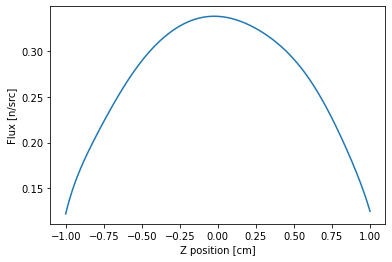

In [24]:
z = np.linspace(zmin, zmax, 1000)
plt.plot(z, phi(z))
plt.xlabel('Z position [cm]')
plt.ylabel('Flux [n/src]')

A rough cosine shape is obtained. 
One can also numerically integrate the function using the trapezoidal rule.

In [25]:
np.trapz(phi(z), z)

0.542522648365342

The following cases show how to reconstruct the flux distribution Zernike polynomials tallied results.

In [26]:
with openmc.StatePoint(sp_file) as sp:
    df2 = sp.tallies[flux_tally_zernike.id].get_pandas_dataframe()

In [27]:
df2

,cell,zernike,nuclide,score,mean,std. dev.
0,4,"Z0,0",total,flux,0.542523,0.000576
1,4,"Z1,-1",total,flux,0.000462,0.000298
2,4,"Z1,1",total,flux,0.000572,0.000323
3,4,"Z2,-2",total,flux,0.000362,0.000228
4,4,"Z2,0",total,flux,-0.064447,0.000328
...,...,...,...,...,...,...
61,4,"Z10,2",total,flux,-0.000015,0.000105
62,4,"Z10,4",total,flux,0.000081,0.000098
63,4,"Z10,6",total,flux,0.000194,0.000094
64,4,"Z10,8",total,flux,-0.000055,0.000090


Let's plot the flux in radial direction with specific azimuthal angle ($\theta = 0.0$).

Text(0, 0.5, 'Flux')

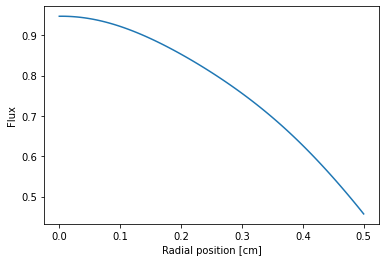

In [28]:
z_n = df2['mean'] 
zz = openmc.Zernike(z_n, radius)
rr = np.linspace(0, radius, 100)
plt.plot(rr, zz(rr, 0.0)) 
plt.xlabel('Radial position [cm]')
plt.ylabel('Flux')

A polar figure with all azimuthal can be plotted like this:

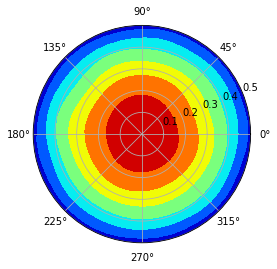

In [29]:
z_n = df2['mean']
zz = openmc.Zernike(z_n, radius=radius) 
#
# Using linspace so that the endpoint of 360 is included...
azimuths = np.radians(np.linspace(0, 360, 50))
zeniths = np.linspace(0, radius, 100)
r, theta = np.meshgrid(zeniths, azimuths)
values = zz(zeniths, azimuths)
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, values, cmap='jet')
plt.show()

Sometimes, we just need the radial-only Zernike polynomial tallied flux distribution. 
Let us extract the tallied coefficients first.

In [30]:
with openmc.StatePoint(sp_file) as sp:
    df3 = sp.tallies[flux_tally_zernike1d.id].get_pandas_dataframe()

In [31]:
df3

,cell,zernikeradial,nuclide,score,mean,std. dev.
0,4,"Z0,0",total,flux,0.542523,0.000576
1,4,"Z2,0",total,flux,-0.064447,0.000328
2,4,"Z4,0",total,flux,0.000327,0.000264
3,4,"Z6,0",total,flux,-0.000730,0.000182
4,4,"Z8,0",total,flux,-0.000073,0.000145
5,4,"Z10,0",total,flux,-0.000176,0.000155


A plot along with r-axis is also done.

Text(0, 0.5, 'Flux')

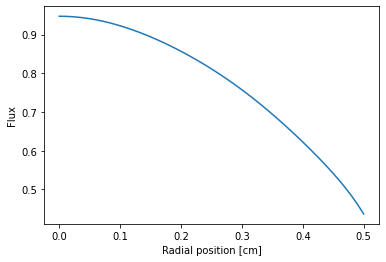

In [32]:
z_n = df3['mean']  
zz = openmc.ZernikeRadial(z_n, radius=radius)
rr = np.linspace(0, radius, 50)
plt.plot(rr, zz(rr)) 
plt.xlabel('Radial position [cm]')
plt.ylabel('Flux')

Similarly, we can also re-construct the polar figure based on radial-only Zernike polinomial coefficients. 

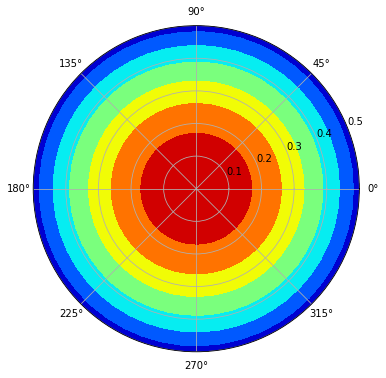

In [33]:
z_n = df3['mean']  
zz = openmc.ZernikeRadial(z_n, radius=radius)
azimuths = np.radians(np.linspace(0, 360, 50))
zeniths = np.linspace(0, radius, 100)
r, theta = np.meshgrid(zeniths, azimuths)
values = [[i for i in zz(zeniths)] for j in range(len(azimuths))]
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(6,6))
ax.contourf(theta, r, values, cmap='jet')
plt.show()

Based on Legendre polynomial coefficients and the azimuthal or radial-only Zernike coefficient, it's possible to reconstruct the flux both on radial and axial directions. 

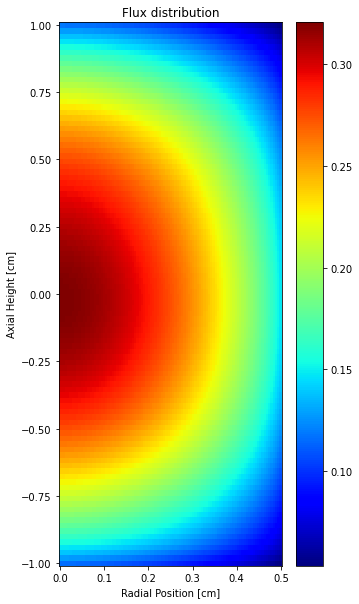

In [34]:
# Reconstruct 3-D flux based on radial only Zernike and Legendre polynomials
z_n = df3['mean']  
zz = openmc.ZernikeRadial(z_n, radius=radius)
azimuths = np.radians(np.linspace(0, 360, 100)) # azimuthal mesh 
zeniths = np.linspace(0, radius, 100) # radial mesh 
zmin, zmax = -1.0, 1.0 
z = np.linspace(zmin, zmax, 100) # axial mesh 
# 
# flux = np.matmul(np.matrix(phi(z)).transpose(), np.matrix(zz(zeniths))) 
# flux = np.array(flux) # change np.matrix to np.array
# np.matrix is not recommended for use anymore
flux = np.array([phi(z)]).T @ np.array([zz(zeniths)])
#
plt.figure(figsize=(5,10))
plt.title('Flux distribution')
plt.xlabel('Radial Position [cm]')
plt.ylabel('Axial Height [cm]')
plt.pcolor(zeniths, z, flux, cmap='jet')
plt.colorbar()

One can also reconstruct the 3D flux distribution based on Legendre and Zernike polynomial tallied coefficients.

In [35]:
# Define needed function first 
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

# Reconstruct 3-D flux based on azimuthal Zernike and Legendre polynomials
z_n = df2['mean']
zz = openmc.Zernike(z_n, radius=radius) 
#
xstep = 2.0*radius/20
hstep = (zmax - zmin)/20
x = np.linspace(-radius, radius, 50)
x = np.array(x)
[X,Y] = np.meshgrid(x,x)
h = np.linspace(zmin, zmax, 50)
h = np.array(h)
[r, theta] = cart2pol(X,Y)
flux3d = np.zeros((len(x), len(x), len(h)))
flux3d.fill(np.nan)
#
for i in range(len(x)):
    for j in range(len(x)):
        if r[i][j]<=radius:
            for k in range(len(h)):
                flux3d[i][j][k] = phi(h[k]) * zz(r[i][j], theta[i][j])

Let us print out with VTK format.

In [36]:
# You'll need to install pyevtk as a prerequisite
from pyevtk.hl import gridToVTK
import numpy as np
#
# Dimensions
nx, ny, nz = len(x), len(x), len(h)
lx, ly, lz = 2.0*radius, 2.0*radius, (zmax-zmin)
dx, dy, dz = lx/nx, ly/ny, lz/nz
#
ncells = nx * ny * nz
npoints = (nx + 1) * (ny + 1) * (nz + 1)
#
# Coordinates
x = np.arange(0, lx + 0.1*dx, dx, dtype='float64')
y = np.arange(0, ly + 0.1*dy, dy, dtype='float64')
z = np.arange(0, lz + 0.1*dz, dz, dtype='float64')
# Print out 
path = gridToVTK("./rectilinear", x, y, z, cellData = {"flux3d" : flux3d})

Use VisIt or ParaView to plot it as you want. Then, the plot can be loaded and shown as follows.

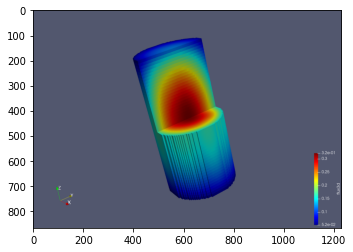

In [37]:
f1 = plt.imread('./images/flux3d.png')
plt.imshow(f1, cmap='jet')